In [1]:
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%pylab inline

import numpy as np
import pandas as pd
import geopandas as gpd

import seaborn as sns

import mgwr
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW

import libpysal
from spreg import GM_Lag
from splot.libpysal import plot_spatial_weights


import statsmodels.api as sm

from sklearn import preprocessing
scale = preprocessing.StandardScaler().fit_transform
from sklearn.metrics import r2_score
from sklearn.linear_model import LassoLarsIC, ElasticNet, ElasticNetCV, MultiTaskLasso

Populating the interactive namespace from numpy and matplotlib


In [2]:
def setFont(ax, font, size):
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname(font)
        label.set_fontsize(size)
    return ax

======== **Table of contents** ========
* [1. Preprocessing](#preprocessing)
* [2. Spatial Analysis](#spatialanalysis)
* [3. Models](#models)
* [4. Feature Selection](#featureselection)
* [5. Spatial Error Model](#sem)
* [6. GWR: Weighted matrix](#gwr)
* [7. SLM: Different scheme](#slmscheme)

# 1. Preprocessing

<a id="1.1"></a>
## 1.1 Target Variables
Here we load the census data, and exctract the target variables

 **Selected Variables:**
 * p1: Fraction of foreigners
 * p2: Fraction of beneficiaries of the social assistance
 * t1: Cars per 1000 inhabitants
 * t2: Fraction of commuters using public transportation
 * w1 : Unemployment rate
 * w2: Unemployment rate between women
 * s1: Building area (%)
 * s2: Green area (%)
 * h1 : Vacancy rate (%)
 * h2: Average area per inhabitant in square meters
 * e1 : Municipal debt
 * e2: Fraction of investment in culture

In [3]:
swissData = pd.read_csv('../Data/swissData.csv') ## 90 variables + BFS Code that identifies the municipalities

tv =  ['pop23', 'pop29', 
       'trpt8','trpt10', 
       'trv11', 'trv2', 
       'esp2', 'esp3',
       'log2', 'log3', 
       'fin4', 'fin7']

nameVariables = ['p1','p2',
                 't1','t2',
                 'w1','w2',
                 's1','s2',
                 'h1','h2',
                 'e1','e2']

VarDescription=nameVariables

clrs = ['darkred', 'darkred',
        'darkgreen', 'darkgreen',
        'teal', 'teal',
         'y','y',
         'dimgray','dimgray',
         'sienna', 'sienna']
sd = swissData.filter(tv, axis=1)
sd.columns = nameVariables

sd['t2'] = sd['t2'] / swissData['trpt9'] ## Divide by the total number of commuters
sd['w2'] = sd['w2'] / swissData['pop3']  ## Divide by the number of women
sd['s1'] = sd['s1'] / swissData['esp1']  ## Divide by the total Area
sd['s2'] = sd['s2'] / swissData['esp1']  ## Divide by the total Area
sd['e1'] = sd['e1'] / swissData['fin1']  ## Divide by the total Revenue
sd['e2'] = sd['e2'] / swissData['fin5']  ## Divide by the total Investment
sd['pop1'] = swissData['pop1']
sd['BFS'] = swissData['BFS']

In [4]:
target_variables={
"p1": "Fraction of foreigners",
"p2": "Fraction of beneficiaries of the social assistance",
"t1": "Cars per 1000 inhabitants",
"t2": "Fraction of commuters using public transportation",
"w1": "Unemployment rate",
"w2": "Unemployment rate between women",
"s1": "Building area (%)",
"s2": "Green area (%)",
"h1": "Vacancy rate (%)",
"h2": "Average area per inhabitant in square meters",
"e1": "Municipal debt",
"e2": "Fraction of investment in culture"}

In [5]:
sd.head()

,p1,p2,t1,t2,w1,w2,s1,s2,h1,h2,e1,e2,pop1,BFS
0,21.35862,3.549010,518.6347,0.386232,2.958045,0.013832,0.264182,0.055105,2.023799,47.85,0.019955,0.126747,21036,4001
1,35.62053,3.106692,476.0431,0.451864,3.936226,0.018199,0.267696,0.046332,0.856740,41.72,0.086333,0.042721,18742,131
2,24.19482,1.317212,561.2726,0.363622,3.730497,0.016996,0.181081,0.028378,0.989899,45.94,0.202755,0.126899,10184,2761
3,27.84874,3.442091,511.5966,0.372149,4.660264,0.018880,0.156752,0.017941,1.229070,44.27,0.121975,0.019021,11900,2
4,40.37747,8.278012,508.3827,0.327198,5.990914,0.021447,0.065814,0.034126,1.124285,38.20,0.084712,0.049193,9961,5401


<a id="1.1"></a>
## 1.2 Features
Here we load the **Insurance Data**, from which we will extract the features or predictors of the various models to predict insurance data

In [6]:
dfFeat = pd.read_csv('../data/featuresListNew.csv')  ## Features of the paper
dfFeat = dfFeat.sort_values(by=['BFS']).reset_index(drop=True)
dfFeat = dfFeat.astype(float)
dfFeatCol = dfFeat.columns  ## columns of the featueres
dfFeatCol = list(dfFeatCol.drop(['BFS']))

###  1.2.1 Features dictionary 
We define a dictionary that contains all the extracted features

In [7]:
features_dict={"f1" : "unemployment rate",
"f2" : "average age in the muncipality",
"f3" : "Fraction of owners (house)",
"f4" :  "Fraction of foreigners",
"f5" :  "Avg number of childer for customers with at least one children",
"f6" :  "Market Share",
"f7" :  "fraction of women",
"f8" :  "Number of customers divided by total customers",
"f9" :  "average price of the cars",
"f10" : "95th percentile price of the cars",
"f11" :  "Average Year of the car",
"f12" :  "5th percentile Year of the car",
"f13" :  "Average CCM of the car",
"f14" :  "95th percentile CCM of the car",
"f15" :  "Average number of claims per cars",
"f16" :  "95th percentile number of claims of the car",
"f17" :  "Average sum of claims of the car",
"f18" :  "95th percentile number of price of the car",
"f19" :  "Average sum of class premium of the car",
"f20" :  "Percent of insured cars",
"f21" :  "Average Class of Forniture",
"f22" :  "95th percentile  class of fornitures",
"f23" :  "Avg Number of Rooms",
"f24" :  "95th percentile  number of rooms",
"f25" :  "Average Building Insured Sum",
"f26" :  "95th Building Insured Sum",
"f27" :  "Average Building Year of Constructions",
"f28" :  "5th Percentile Building Year of Constructions",
"f29" :  "Average type of Building",
"f30" :  "Average number of claims per building",
"f31" :  "Average Sum of claims per building",
"f32" :  "95th Sum of claims per building",
"f33" :  "Average Insured Premium",
"f34" :  "95th Sum of Insured Premium"}

feature_names=list(features_dict.keys())

<a id="spatialanalysis"></a> 
# 2. Spatial Analysis
 * back to [Table of Contents](#toc)

#### 2.1 Load shaperfile of municipality and cantons

In [8]:
mun       = gpd.read_file('../data/shapeFiles/municipalities.shp')
mun       = mun.to_crs({'init': 'epsg:21781'})
mun.drop_duplicates(subset='BFS_NUMMER', keep="last",inplace=True)
mun_ = mun.filter(['BFS_NUMMER', 'geometry'])

cantons   = gpd.read_file("../data/shapeFiles/cantons.shp")
cantons   = cantons.to_crs({'init': 'epsg:21781'})

dfData = dfFeat.copy()
dfData = dfData.merge(sd, on ='BFS')
dfData['categories']=0
dfData.loc[dfData['pop1'] > 25000, 'categories'] = 1
dfData.loc[dfData['pop1'] > 80000, 'categories'] = 2

dfData = pd.merge(dfData, mun_, left_on ='BFS', right_on='BFS_NUMMER')
dfData = gpd.GeoDataFrame(dfData,geometry='geometry')
coord = pd.read_csv('../data/bfs_name_coordinates.csv',delimiter=',', encoding="iso-8859-1")
dfData = pd.merge(dfData, coord, on = 'BFS')
dfData['g_coords'] = list(zip(dfData['Xcoord'],dfData['Ycoord']))
g_coords = list(dfData.g_coords.values)

In [9]:
### 2.2 Create matrix weights for our analysis
from libpysal.weights import KNN, Kernel
w_knn = KNN.from_dataframe(dfData)
w_gaussian = Kernel.from_dataframe(dfData, function='gaussian')

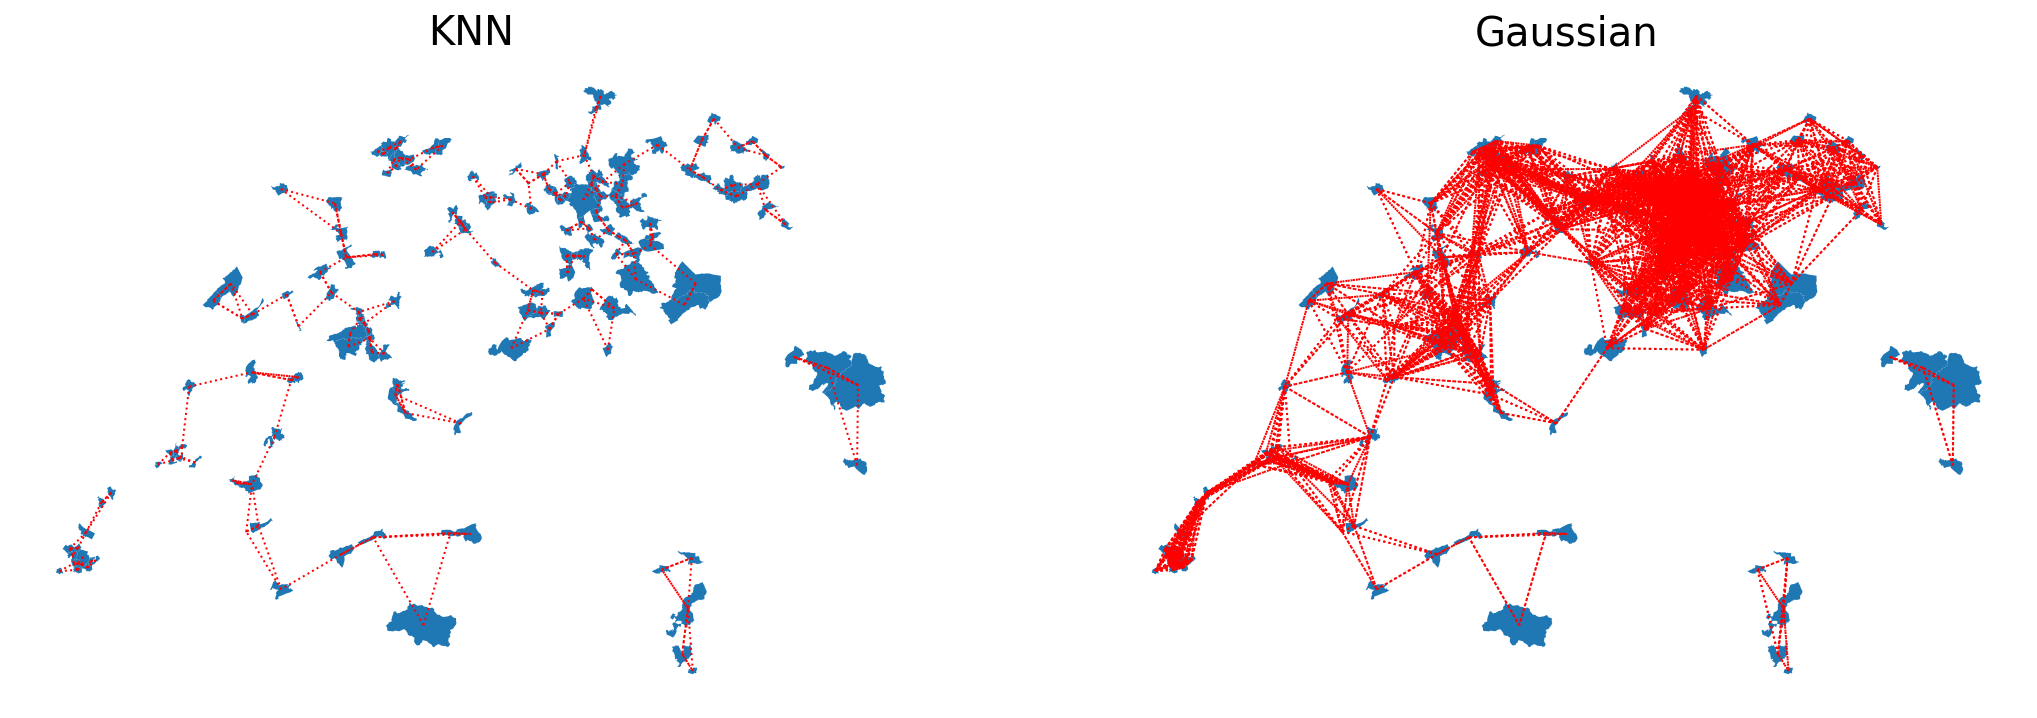

In [10]:
f, ax = plt.subplots(1,2,figsize=(18,6))
ax0 = ax[0]
ax0 = setFont(ax0, 'Arial', 18)
w_knn.plot(dfData, ax=ax0,
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
dfData.plot(ax=ax0)
ax0.set_title('KNN', size=20)
ax0.axis('off');

ax1 = ax[1]
ax1 = setFont(ax1, 'Arial', 18)
w_gaussian.plot(dfData, ax=ax1,
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
dfData.plot(ax=ax1)
ax1.set_title('Gaussian', size=20)
ax1.axis('off');

<a id="Models"></a> 
# 3. Models
* back to [Table of Contents](#toc)

We introduce 3 different models:

* [OLS]: Stander Ordinary Least Square 
* [GWR]: Geographical Weighted Regression
* [SLM]: Spatial Lagged Model

In [11]:
def extract_scale_features(df,target_var,predictor_vars):
    return scale(df[predictor_vars].values),scale(df[target_var].values.reshape(-1, 1))

In [12]:
def run_OLS(df,target_var, predictor_vars):    
    X,y = extract_scale_features(df,target_var,predictor_vars)
    estimator  = sm.OLS(y, sm.add_constant(X)).fit()
    return estimator

In [13]:
def run_GWR(df,target_var,predictor_vars):
    X,y = extract_scale_features(df,target_var,predictor_vars)
    g_coords = list(df.g_coords.values)
    gwr_bandwidth = Sel_BW(g_coords, y, X, kernel='exponential', fixed=True).search(criterion='AICc')
    estimator = GWR(g_coords, y, X, gwr_bandwidth, kernel='gaussian', fixed=True).fit()
    return estimator

In [14]:
def generate_W_knn(df, p, k):
    kd = libpysal.cg.KDTree(df[['Xcoord','Ycoord']].values)
    return libpysal.weights.KNN(kd, p=p, k=k)

W_knn = generate_W_knn(dfData, 2, 5)
def run_SLM(df,target_var, predictor_vars, W = W_knn): 
    X,y = extract_scale_features(df,target_var,predictor_vars)
    estimator = GM_Lag(y, X, w=W, spat_diag=True, w_lags=2)        
    return estimator

In [15]:
def get_r2(est):
    try:
        return est.R2
    except:
        pass
    try:
        return est.rsquared
    except:
        pass
    try:
        return r2_score(est.y,est.predy)
    except:
        return np.nan

<a id="featureselection"></a> 

# 4. Feature Selection
* back to [Table of Contents](#toc)

In [16]:
def feature_selection(df,target_var,predictor_vars=dfFeatCol):
    xNorm,yNorm = extract_scale_features(df,target_var,predictor_vars)

    model_bic = LassoLarsIC(criterion='bic',normalize=False)
    model_bic.fit(xNorm, ravel(yNorm))
    
    return [predictor_vars[i] for i in np.squeeze(np.nonzero(model_bic.coef_))]

def feature_selection_elasticNet(df,target_var,predictor_vars=dfFeatCol):
    xNorm,yNorm = extract_scale_features(df,target_var,predictor_vars)

    model_elastic = ElasticNetCV(cv=20, random_state=0)
    model_elastic.fit(xNorm, ravel(yNorm))
    return [predictor_vars[i] for i in np.squeeze(np.nonzero(model_elastic.coef_))]

### 4.1 Lasso

In [17]:
selected_feats={}
selected_models={}
g_coords = list(dfData.g_coords.values)
nfeatLasso = []
for i,target in enumerate(target_variables):
    varnames = feature_selection(dfData,target)
    selected_feats[target] = varnames
    ##run the different models with the selected variables
    est_ols = run_OLS(dfData,target,varnames)
    est_gwr = run_GWR(dfData,target,varnames)
    est_slm = run_SLM(dfData,target,varnames, W = W_knn)
    selected_models[target] = [est_ols,est_gwr,est_slm]
    nfeatLasso.append(len(varnames))

In [18]:
cols = ['target_variable','model','r2']
df_r2=pd.DataFrame(columns=cols)
for i,j in zip(selected_models.keys(),selected_models.values()):
    for est, model in zip(j,['OLS','GWR','SLM']):
        df_r2=df_r2.append(pd.DataFrame(columns=cols,data=[[i,model,get_r2(est)]]),ignore_index=True)

(0.0, 1.0)

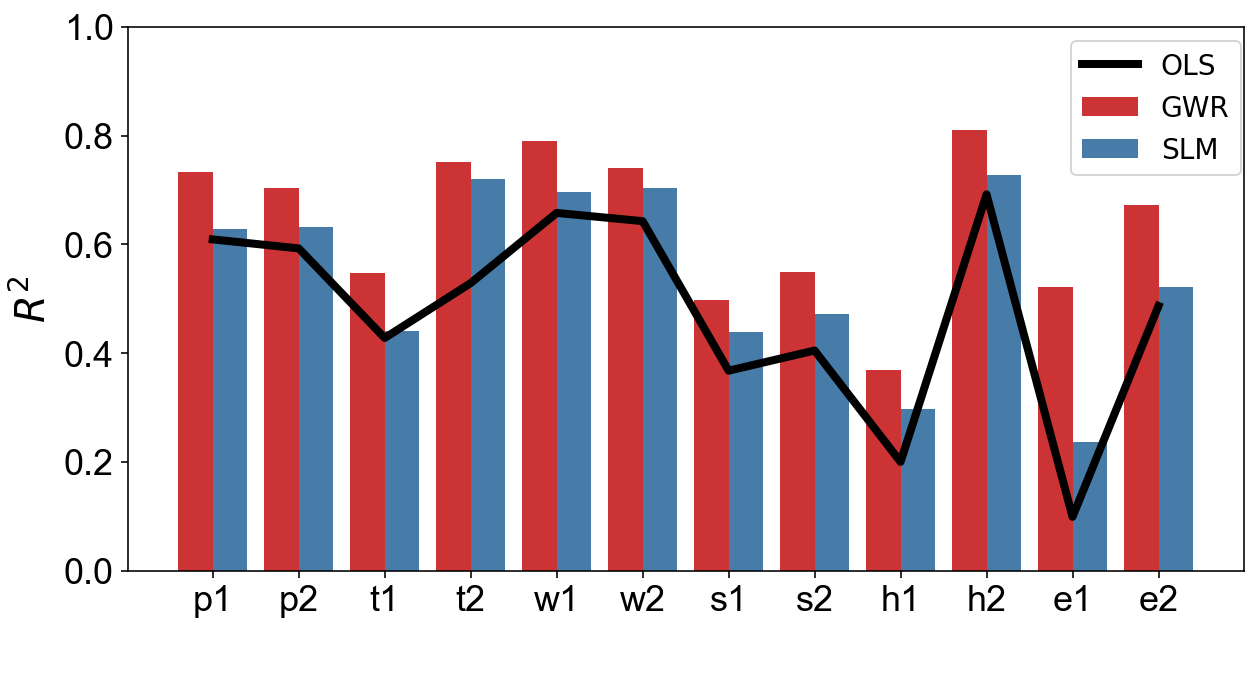

In [19]:
f, ax = plt.subplots(figsize=(10, 5))
ax = setFont(ax, 'Arial', 18)
tmp = df_r2[df_r2['model']!='OLS']
sns.barplot(data=tmp,hue='model',x='target_variable',y='r2', palette='Set1')
tmp = df_r2[df_r2['model']=='OLS']
ax.plot(tmp['target_variable'], tmp['r2'], color='black', lw=4, label='OLS')
ax.set_ylabel(r'$R^2$', size=20)
ax.set_xlabel(r' ', size=20)
ax.legend(fontsize=14, bbox_to_anchor=(1.01,1))
ax.set_ylim((0,1))

In [20]:
df_r2_lasso = df_r2

### 4.2 ElasticNet

In [21]:
selected_feats={}
selected_models={}
g_coords = list(dfData.g_coords.values)
nfeatElNet = []
for i,target in enumerate(target_variables):
    varnames = feature_selection_elasticNet(dfData,target)
    selected_feats[target] = varnames
    ##run the different models with the selected variables
    est_ols = run_OLS(dfData,target,varnames)
    est_gwr = run_GWR(dfData,target,varnames)
    est_slm = run_SLM(dfData,target,varnames, W = W_knn)
    selected_models[target] = [est_ols,est_gwr,est_slm]
    nfeatElNet.append(len(varnames))

(0.0, 1.0)

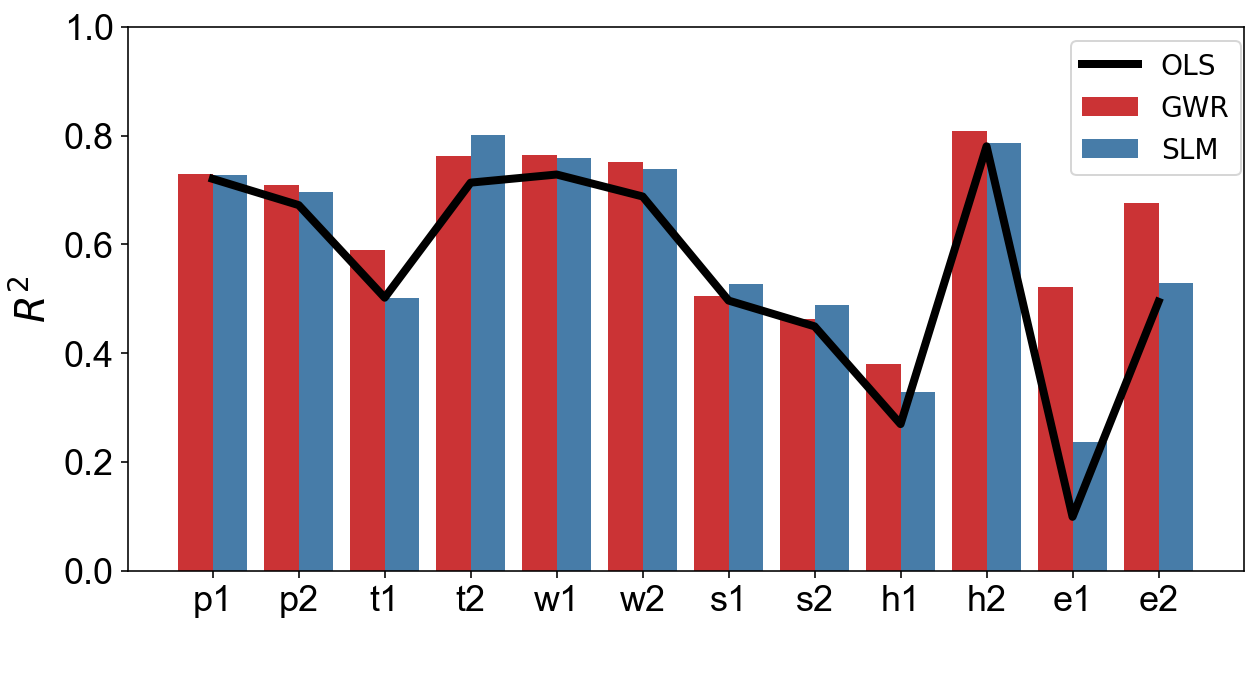

In [22]:
cols = ['target_variable','model','r2']
df_r2=pd.DataFrame(columns=cols)
for i,j in zip(selected_models.keys(),selected_models.values()):
    for est, model in zip(j,['OLS','GWR','SLM']):
        df_r2=df_r2.append(pd.DataFrame(columns=cols,data=[[i,model,get_r2(est)]]),ignore_index=True)
        

f, ax = plt.subplots(figsize=(10, 5))
ax = setFont(ax, 'Arial', 18)
tmp = df_r2[df_r2['model']!='OLS']
sns.barplot(data=tmp,hue='model',x='target_variable',y='r2', palette='Set1')
tmp = df_r2[df_r2['model']=='OLS']
ax.plot(tmp['target_variable'], tmp['r2'], color='black', lw=4, label='OLS')
ax.set_ylabel(r'$R^2$', size=20)
ax.set_xlabel(r' ', size=20)
ax.legend(fontsize=14, bbox_to_anchor=(1.01,1))
ax.set_ylim((0,1))

In [23]:
df_r2_elnet = df_r2

### 4.3 Constrained Lasso

In [25]:
Y = sd.drop(['pop1', 'BFS'], axis=1)
coef_multi_task_lasso_ = MultiTaskLasso(alpha=1.)
X = dfFeat.drop(['BFS'], axis=1)
X = np.array(X)
xNorm = scale(X)
yNorm = scale(Y)
coef_multi_task_lasso_.fit(X, Y)
feats  = np.squeeze(np.nonzero(coef_multi_task_lasso_.coef_))
feats = feats[1][0:23]
featuresCL = []  ## features for constrained lasso
for i in feats:
    featuresCL.append(dfFeatCol[i])

In [26]:
selected_feats={}
selected_models={}
g_coords = list(dfData.g_coords.values)
varnames = featuresCL
for i,target in enumerate(target_variables):
    est_ols = run_OLS(dfData,target,varnames)
    est_gwr = run_GWR(dfData,target,varnames)
    est_slm = run_SLM(dfData,target,varnames, W = W_knn)
    selected_models[target] = [est_ols,est_gwr,est_slm]

(0.0, 1.0)

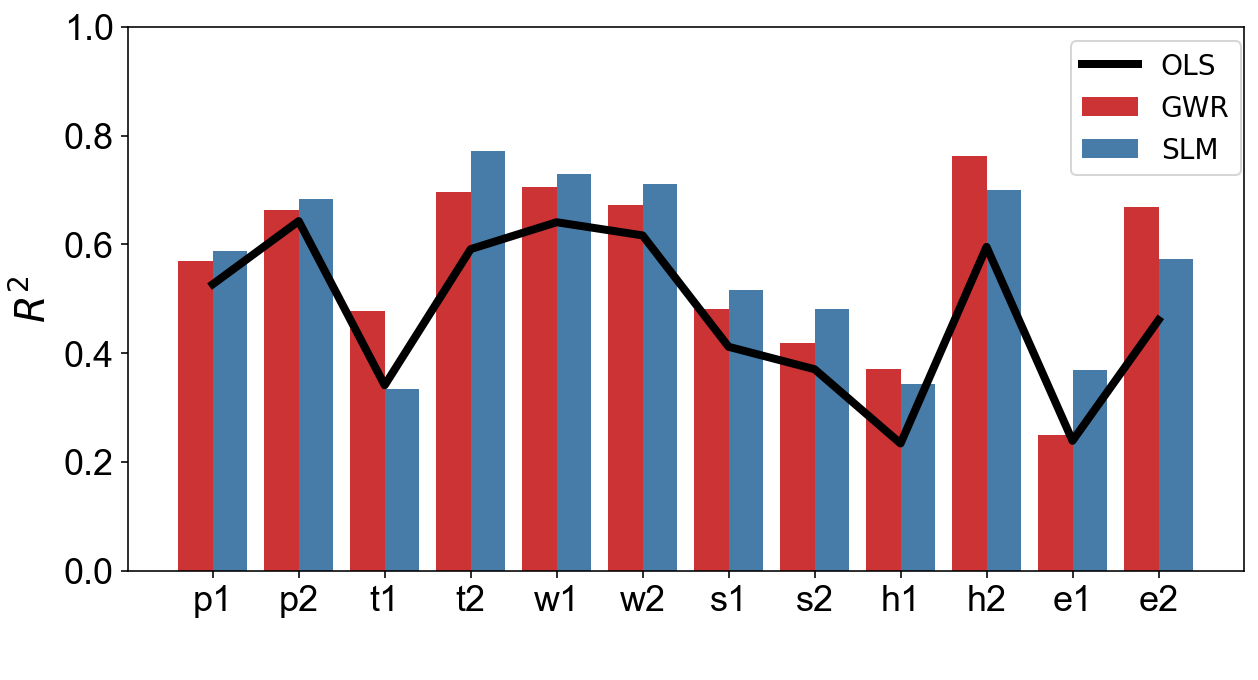

In [27]:
cols = ['target_variable','model','r2']
df_r2=pd.DataFrame(columns=cols)
for i,j in zip(selected_models.keys(),selected_models.values()):
    for est, model in zip(j,['OLS','GWR','SLM']):
        df_r2=df_r2.append(pd.DataFrame(columns=cols,data=[[i,model,get_r2(est)]]),ignore_index=True)
        

f, ax = plt.subplots(figsize=(10, 5))
ax = setFont(ax, 'Arial', 18)
tmp = df_r2[df_r2['model']!='OLS']
sns.barplot(data=tmp,hue='model',x='target_variable',y='r2', palette='Set1')
tmp = df_r2[df_r2['model']=='OLS']
ax.plot(tmp['target_variable'], tmp['r2'], color='black', lw=4, label='OLS')
ax.set_ylabel(r'$R^2$', size=20)
ax.set_xlabel(r' ', size=20)
ax.legend(fontsize=14, bbox_to_anchor=(1.01,1))
ax.set_ylim((0,1))

In [28]:
df_r2_cl = df_r2

### 4.4 Comparison 

In [29]:
### df_r2_lasso
### df_r2_elnet
### df_r2_cl

In [30]:
def tableR2(df_r2_lasso, df_r2_elnet, df_r2_cl, model):
    tmp1 = df_r2_lasso[df_r2_lasso['model']==model]
    tmp2 = df_r2_elnet[df_r2_elnet['model']==model]
    tmp3 = df_r2_cl[df_r2_cl['model']==model]
    tmp1['featSel']='Lasso'
    tmp2['featSel']='ElNet'
    tmp3['featSel']='Constr. Lasso'
    df = pd.concat([tmp1, tmp2], ignore_index=True)
    df = pd.concat([df, tmp3], ignore_index=True)
    return df

Text(0.5, 1.0, 'OLS')

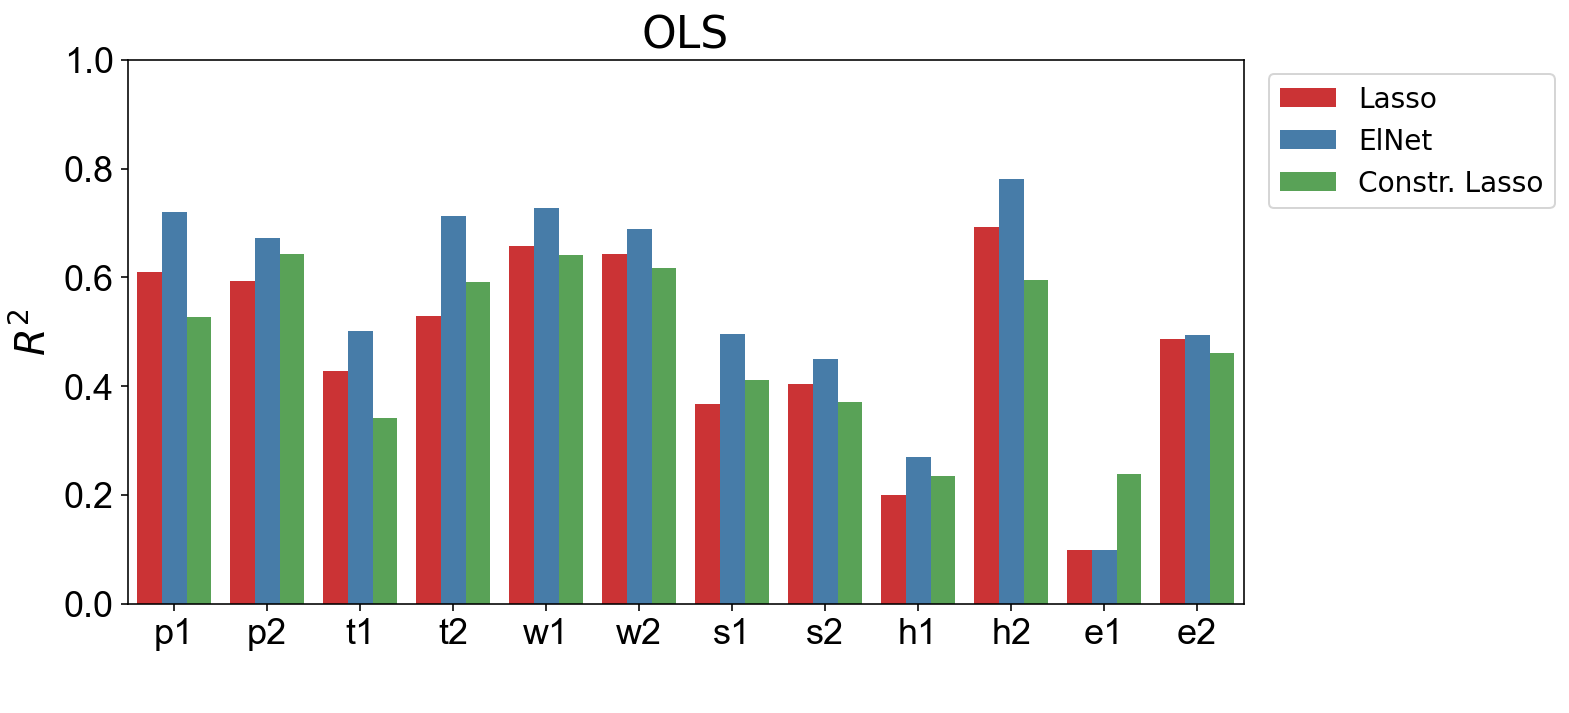

In [31]:
model = 'OLS'
dfR2OLS = tableR2(df_r2_lasso, df_r2_elnet, df_r2_cl, model)
f, ax = plt.subplots(figsize=(10, 5))
ax = setFont(ax, 'Arial', 18)
sns.barplot(data=dfR2OLS,hue='featSel',x='target_variable',y='r2', palette='Set1')
ax.legend(fontsize=14, bbox_to_anchor=(1.01,1))
ax.set_ylim((0,1))
ax.set_ylabel(r'$R^2$', size=20)
ax.set_xlabel(r' ', size=20)
ax.set_title(model, size = 22)

In [32]:
tmp = dfR2OLS[dfR2OLS['featSel']=='Lasso']
print(tmp['r2'].mean())
tmp = dfR2OLS[dfR2OLS['featSel']=='ElNet']
print(tmp['r2'].mean())
tmp = dfR2OLS[dfR2OLS['featSel']=='Constr. Lasso']
print(tmp['r2'].mean())

0.4758469110538737
0.5512531277774605
0.4725554661824894


Text(0.5, 1.0, 'SLM')

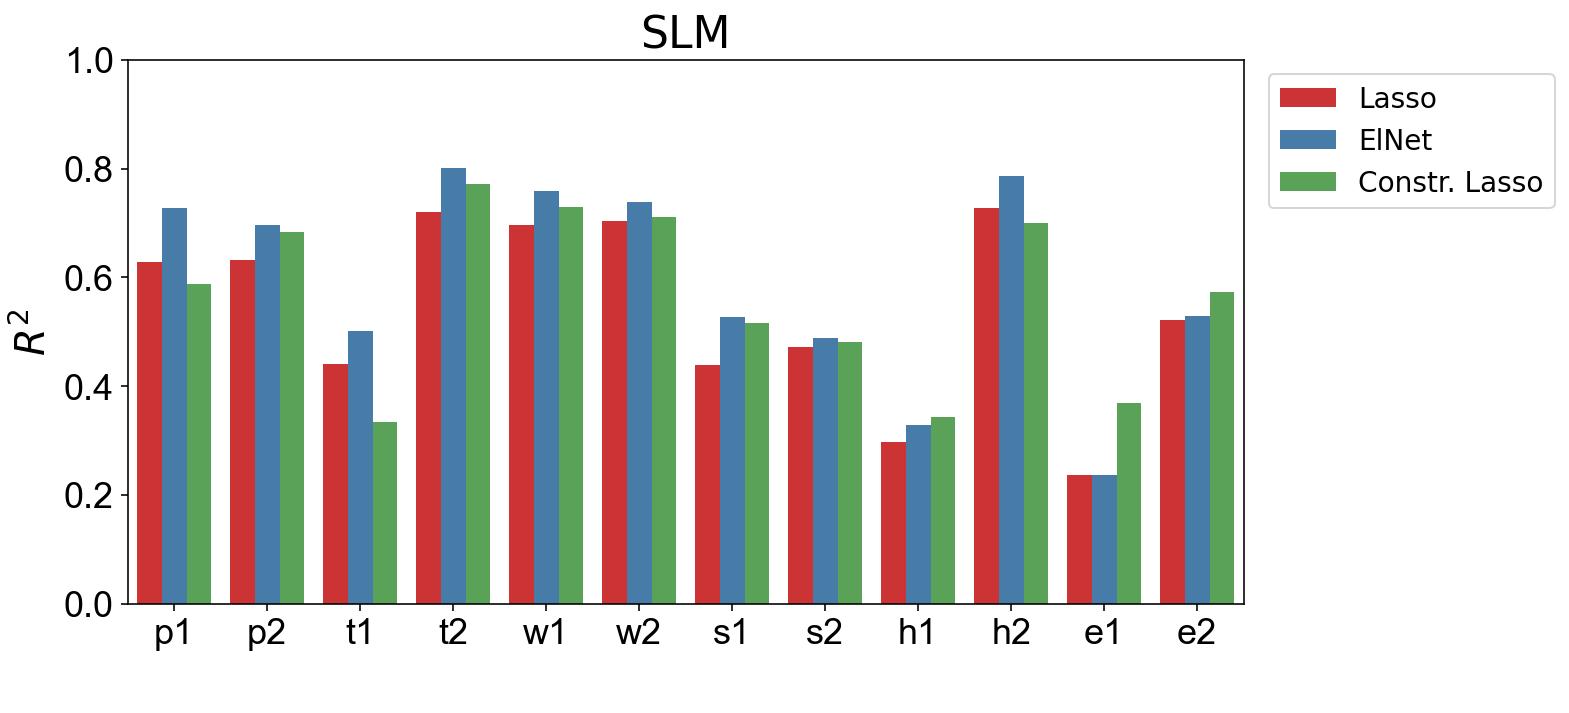

In [33]:
model = 'SLM'
dfR2SLM = tableR2(df_r2_lasso, df_r2_elnet, df_r2_cl, model)
f, ax = plt.subplots(figsize=(10, 5))
ax = setFont(ax, 'Arial', 18)
sns.barplot(data=dfR2SLM,hue='featSel',x='target_variable',y='r2', palette='Set1')
ax.legend(fontsize=14, bbox_to_anchor=(1.01,1))
ax.set_ylim((0,1))
ax.set_ylabel(r'$R^2$', size=20)
ax.set_xlabel(r' ', size=20)
ax.set_title(model, size = 22)

In [34]:
tmp = dfR2SLM[dfR2SLM['featSel']=='Lasso']
print(tmp['r2'].mean())
tmp = dfR2SLM[dfR2SLM['featSel']=='ElNet']
print(tmp['r2'].mean())
tmp = dfR2SLM[dfR2SLM['featSel']=='Constr. Lasso']
print(tmp['r2'].mean())

0.5431477057807094
0.5935717364472216
0.5667052245664927


Text(0.5, 1.0, 'GWR')

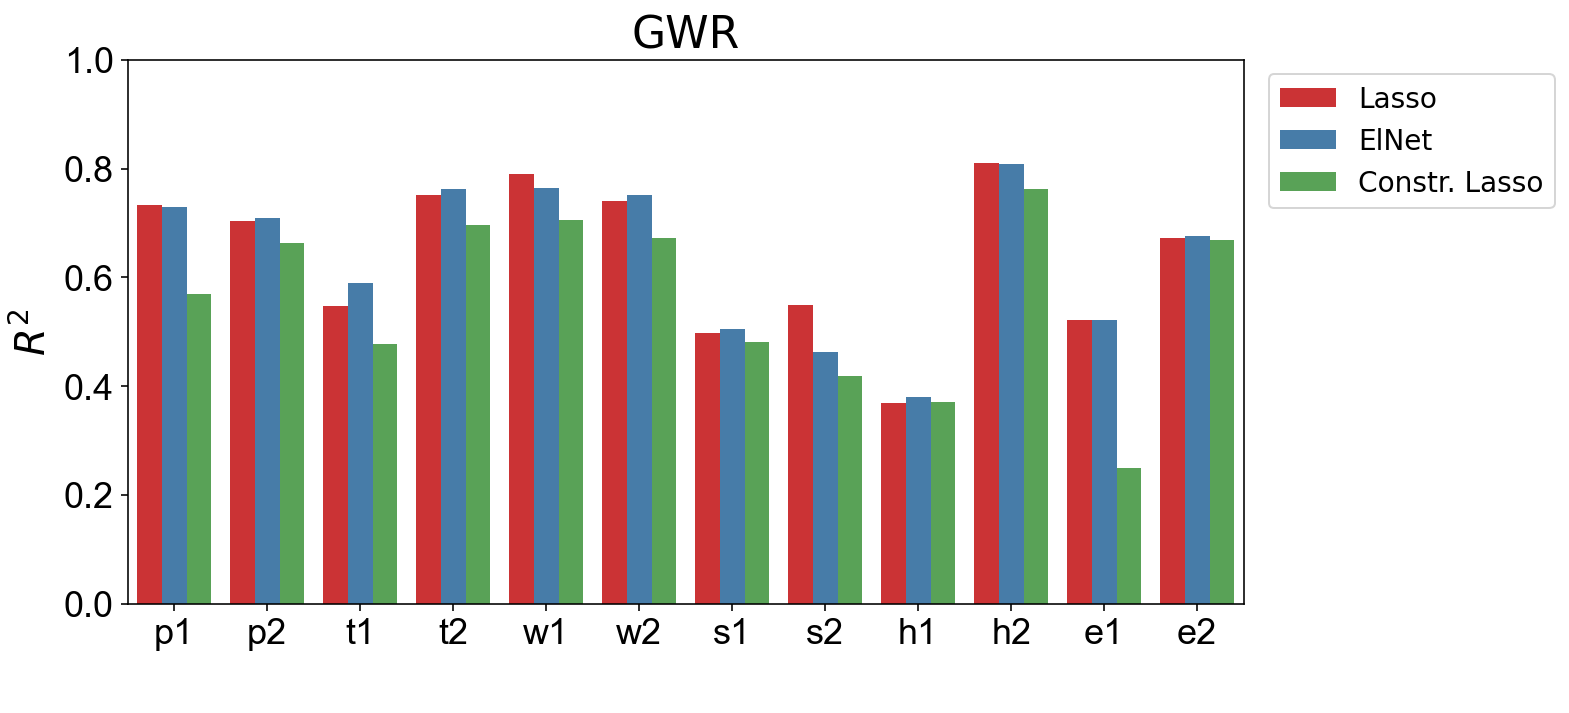

In [35]:
model = 'GWR'
dfR2GWR = tableR2(df_r2_lasso, df_r2_elnet, df_r2_cl, model)
f, ax = plt.subplots(figsize=(10, 5))
ax = setFont(ax, 'Arial', 18)
sns.barplot(data=dfR2GWR,hue='featSel',x='target_variable',y='r2', palette='Set1')
ax.legend(fontsize=14, bbox_to_anchor=(1.01,1))
ax.set_ylim((0,1))
ax.set_ylabel(r'$R^2$', size=20)
ax.set_xlabel(r' ', size=20)
ax.set_title(model, size = 22)

In [36]:
tmp = dfR2GWR[dfR2GWR['featSel']=='Lasso']
print(tmp['r2'].mean())
tmp = dfR2GWR[dfR2GWR['featSel']=='ElNet']
print(tmp['r2'].mean())
tmp = dfR2GWR[dfR2GWR['featSel']=='Constr. Lasso']
print(tmp['r2'].mean())

0.6406177374337926
0.638601341995735
0.561375581240861


#### 4.5 Number of selected features

In [37]:
nfeatCL=[]
for i in range(0,12):
    nfeatCL.append(len(featuresCL))

Text(0, 0.5, 'Selected features')

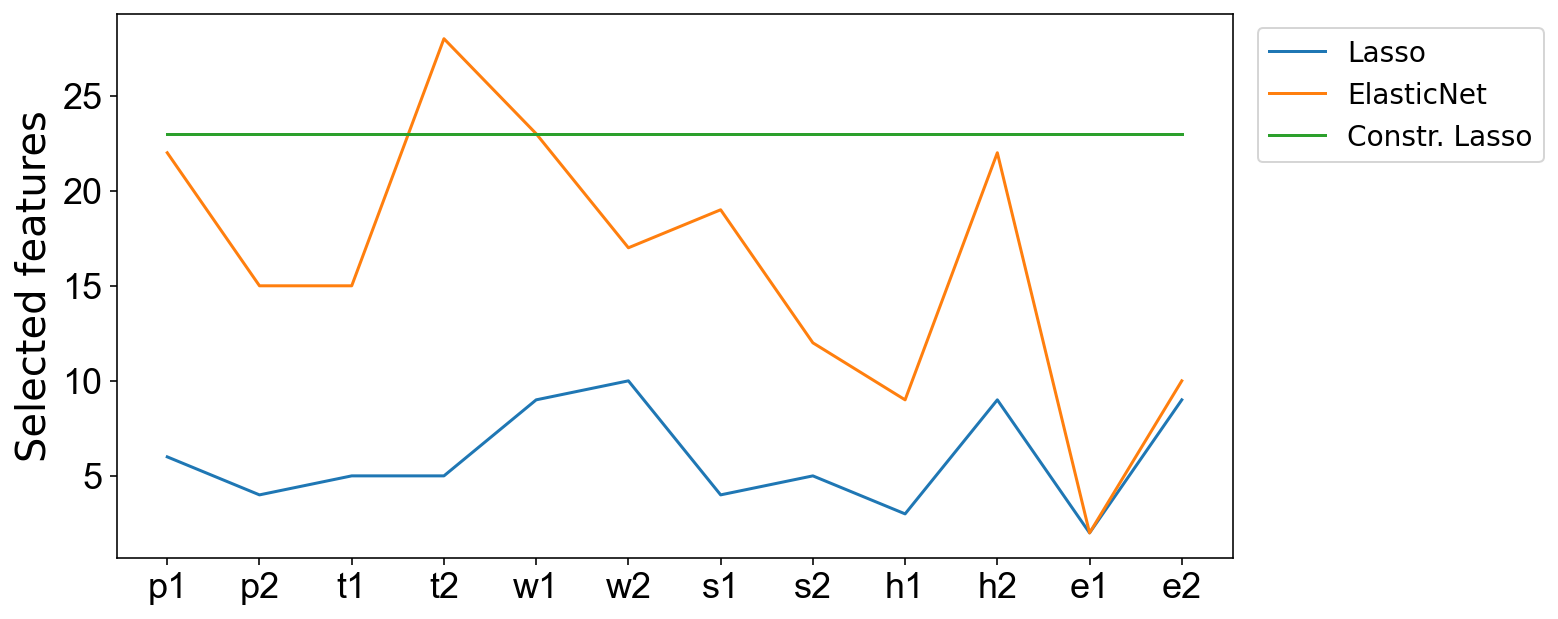

In [38]:
f, ax = plt.subplots(figsize=(10, 5))
ax = setFont(ax, 'Arial', 18)
plt.plot(tmp['target_variable'], nfeatLasso, label='Lasso')
plt.plot(nfeatElNet, label='ElasticNet')
plt.plot(nfeatCL, label = 'Constr. Lasso')
ax.legend(fontsize=14, bbox_to_anchor=(1.01,1))
ax.set_ylabel('Selected features', size=20)


In [39]:
np.mean(nfeatLasso)

5.916666666666667

In [40]:
np.mean(nfeatElNet)

16.166666666666668

In [41]:
nfeatCL

[23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23]

### 4.6 Different number of features

In [55]:
### Diffrent number of features
## we choose constrained lasso with different values of alpha that allow us to have different number of features
## see https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.MultiTaskLasso.html
## alpha = 0.1 ---> nf = 31
## alpha = 1 ---> nf = 23
## alpha = 10 ---> nf = 16
## alpha = 1000 ---> nf = 6
## alpha = 10000 ---> nf = 3
alphas = [0.1, 1, 10, 1000, 10000]
Y = sd.drop(['pop1', 'BFS'], axis=1)
#X = dfFeat.drop(['BFS'], axis=.1)
#X = np.array(X)
FEATS = []
for alpha in alphas:
    coef_multi_task_lasso_ = MultiTaskLasso(alpha=alpha)
    xNorm = scale(X)
    yNorm = scale(Y)
    coef_multi_task_lasso_.fit(X, Y)
    feats  = np.squeeze(np.nonzero(coef_multi_task_lasso_.coef_))[1]
    FEATS.append(feats[0:len(np.unique(feats))])

In [80]:
W_knn = generate_W_knn(dfData, 2, 5)
def run_SLM_mod(df,target_var, predictor_vars, W = W_knn): 
    X,y = extract_scale_features(df,target_var,predictor_vars)
    estimator = GM_Lag(y, X, w=W, spat_diag=True, w_lags=5)        
    return estimator

In [83]:
g_coords = list(dfData.g_coords.values)
R2 = []
for j,f in enumerate(FEATS):
    varnames = []  ## features for constrained lasso
    for i in f:
        varnames.append(dfFeatCol[i])
    selected_feats={}
    selected_models={}
    for i,target in enumerate(target_variables):
        est_ols = run_OLS(dfData,target,varnames)
        est_gwr = run_GWR(dfData,target,varnames)
        if j > 2:
            est_slm = run_SLM_mod(dfData,target,varnames, W = W_knn)
        else:
            est_slm = run_SLM(dfData,target,varnames, W = W_knn)
        selected_models[target] = [est_ols,est_gwr,est_slm]

    cols = ['target_variable','model','r2']
    df_r2=pd.DataFrame(columns=cols)
    for i,j in zip(selected_models.keys(),selected_models.values()):
        for est, model in zip(j,['OLS','GWR','SLM']):
            df_r2=df_r2.append(pd.DataFrame(columns=cols,data=[[i,model,get_r2(est)]]),ignore_index=True)
    R2.append(df_r2)

Text(0.5, 1.0, 'OLS')

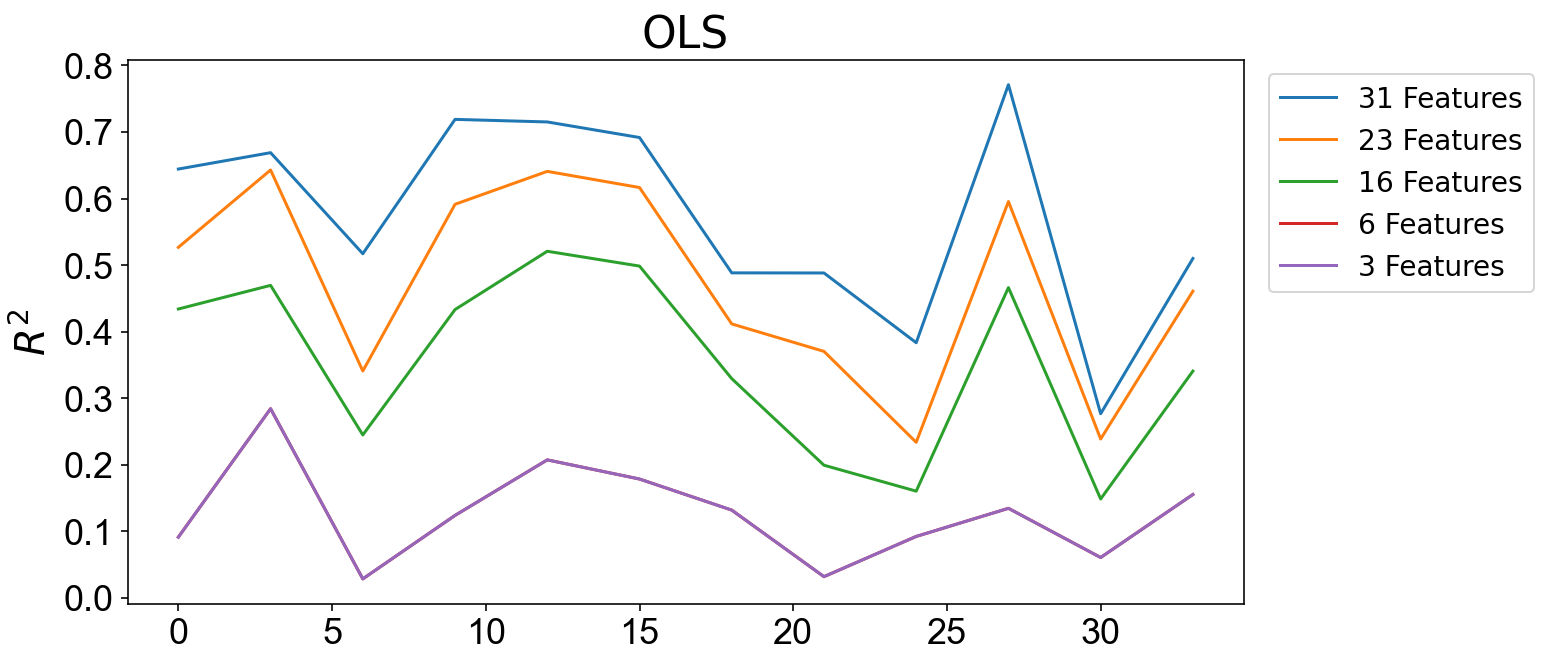

In [92]:
model = 'OLS'
tmp0 = R2[0]
tmp0 = tmp0[tmp0['model']==model]
tmp1 = R2[1]
tmp1 = tmp1[tmp1['model']==model]
tmp2 = R2[2]
tmp2 = tmp2[tmp2['model']==model]
tmp3 = R2[3]
tmp3 = tmp3[tmp3['model']==model]
tmp4 = R2[4]
tmp4 = tmp4[tmp4['model']==model]

f, ax = plt.subplots(figsize=(10, 5))
ax = setFont(ax, 'Arial', 18)
tmp0.r2.plot(label = '31 Features')
tmp1.r2.plot(label = '23 Features')
tmp2.r2.plot(label = '16 Features')
tmp3.r2.plot(label = '6 Features')
tmp3.r2.plot(label = '3 Features')
ax.legend(fontsize=14, bbox_to_anchor=(1.01,1))
ax.set_ylabel(r'$R^2$', size=20)
ax.set_title(model, size = 22)


0.5728478112954444 0.4725554661824894 0.3538711884536121 0.1268047453253314 0.08977259186102811


0.5927929594785524 0.561375581240861 0.5519510561669707 0.5073001817776501 0.5569099626370828


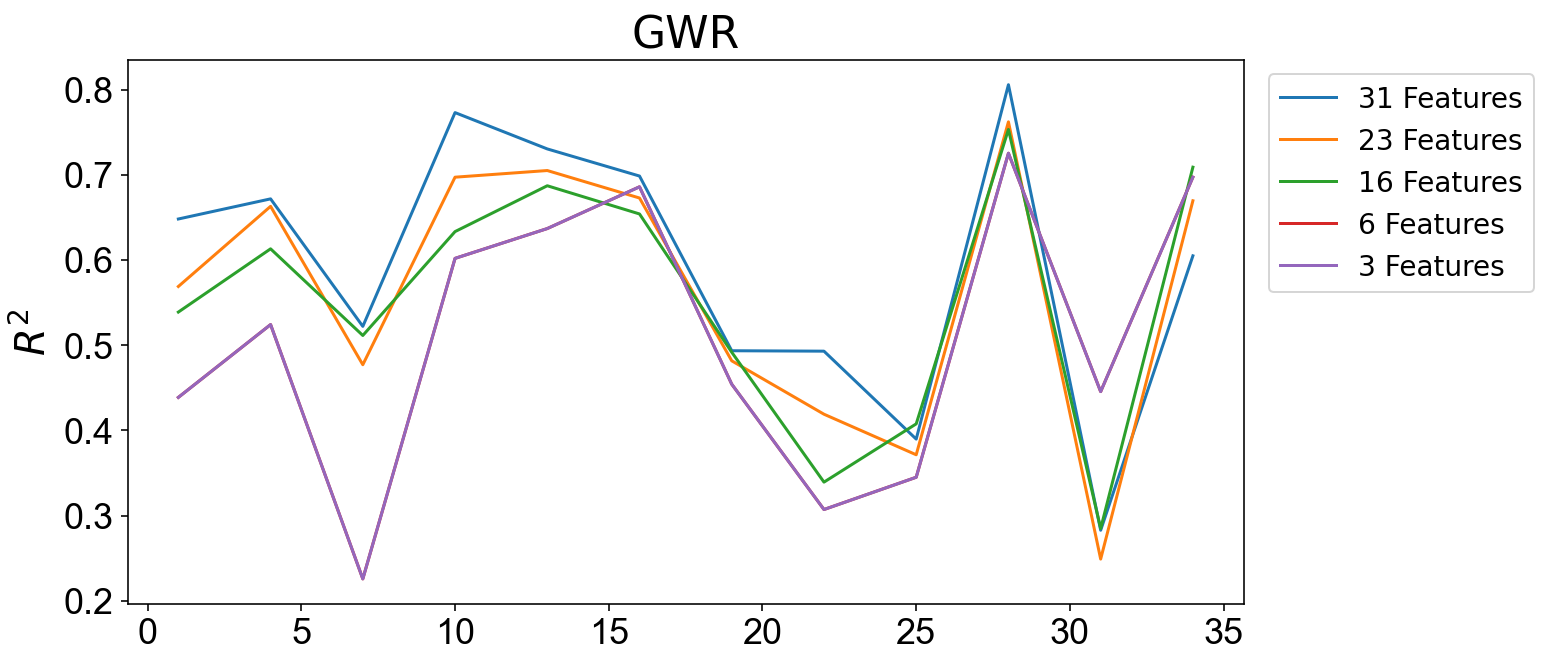

In [95]:
model = 'GWR'
tmp0 = R2[0]
tmp0 = tmp0[tmp0['model']==model]
tmp1 = R2[1]
tmp1 = tmp1[tmp1['model']==model]
tmp2 = R2[2]
tmp2 = tmp2[tmp2['model']==model]
tmp3 = R2[3]
tmp3 = tmp3[tmp3['model']==model]
tmp4 = R2[4]
tmp4 = tmp4[tmp4['model']==model]

f, ax = plt.subplots(figsize=(10, 5))
ax = setFont(ax, 'Arial', 18)
tmp0.r2.plot(label = '31 Features')
tmp1.r2.plot(label = '23 Features')
tmp2.r2.plot(label = '16 Features')
tmp3.r2.plot(label = '6 Features')
tmp3.r2.plot(label = '3 Features')
ax.legend(fontsize=14, bbox_to_anchor=(1.01,1))
ax.set_ylabel(r'$R^2$', size=20)
ax.set_title(model, size = 22)

print(tmp0.r2.mean(),tmp1.r2.mean(),tmp2.r2.mean(),tmp3.r2.mean(),tmp4.r2.mean())

0.6154924116121215 0.5667052245664927 0.5066594064613358 0.39883337210690883 0.382201410319089


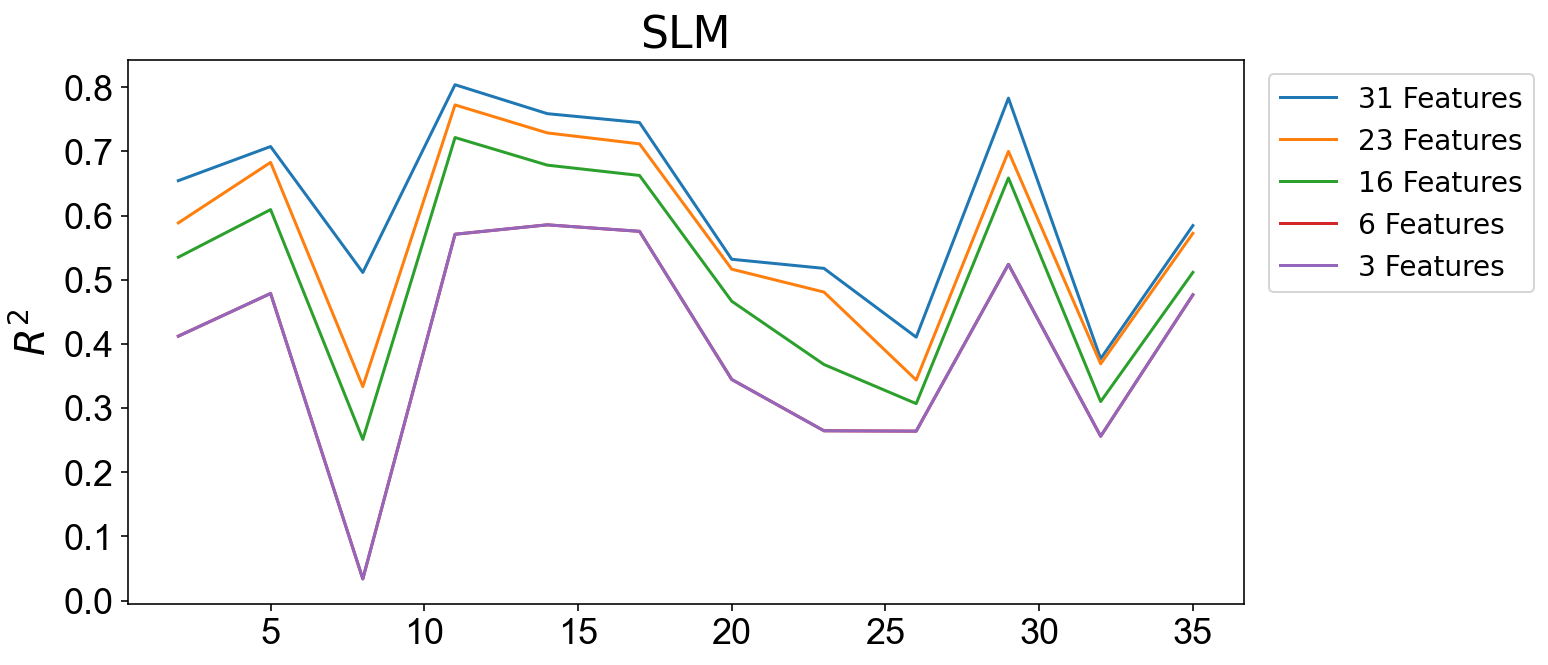

In [96]:
model = 'SLM'
tmp0 = R2[0]
tmp0 = tmp0[tmp0['model']==model]
tmp1 = R2[1]
tmp1 = tmp1[tmp1['model']==model]
tmp2 = R2[2]
tmp2 = tmp2[tmp2['model']==model]
tmp3 = R2[3]
tmp3 = tmp3[tmp3['model']==model]
tmp4 = R2[4]
tmp4 = tmp4[tmp4['model']==model]

f, ax = plt.subplots(figsize=(10, 5))
ax = setFont(ax, 'Arial', 18)
tmp0.r2.plot(label = '31 Features')
tmp1.r2.plot(label = '23 Features')
tmp2.r2.plot(label = '16 Features')
tmp3.r2.plot(label = '6 Features')
tmp3.r2.plot(label = '3 Features')
ax.legend(fontsize=14, bbox_to_anchor=(1.01,1))
ax.set_ylabel(r'$R^2$', size=20)
ax.set_title(model, size = 22)

print(tmp0.r2.mean(),tmp1.r2.mean(),tmp2.r2.mean(),tmp3.r2.mean(),tmp4.r2.mean())

<a id="sem"></a> 
# 5 Spatial Error Model
 * back to [Table of Contents](#toc)

In [97]:
W_knn = generate_W_knn(dfData, 2, 5)
def run_SEM(df,target_var, predictor_vars, W = W_knn): 
    X,y = extract_scale_features(df,target_var,predictor_vars)
    estimator = GM_Lag(y, X, w=W)        
    return estimator

In [98]:
selected_models={}
g_coords = list(dfData.g_coords.values)
for i,target in enumerate(target_variables):
    varnames = feature_selection(dfData,target)
    selected_feats[target] = varnames
    ##run the different models with the selected variables
    est_slm = run_SLM(dfData,target,varnames, W = W_knn)
    est_sem = run_SEM(dfData,target,varnames, W = W_knn)
    selected_models[target] = [est_slm, est_sem]

In [99]:
cols = ['target_variable','model','r2']
df_r2=pd.DataFrame(columns=cols)
for i,j in zip(selected_models.keys(),selected_models.values()):
    for est, model in zip(j,['SLM', 'SEM']):
        df_r2=df_r2.append(pd.DataFrame(columns=cols,data=[[i,model,get_r2(est)]]),ignore_index=True)

(0.0, 1.0)

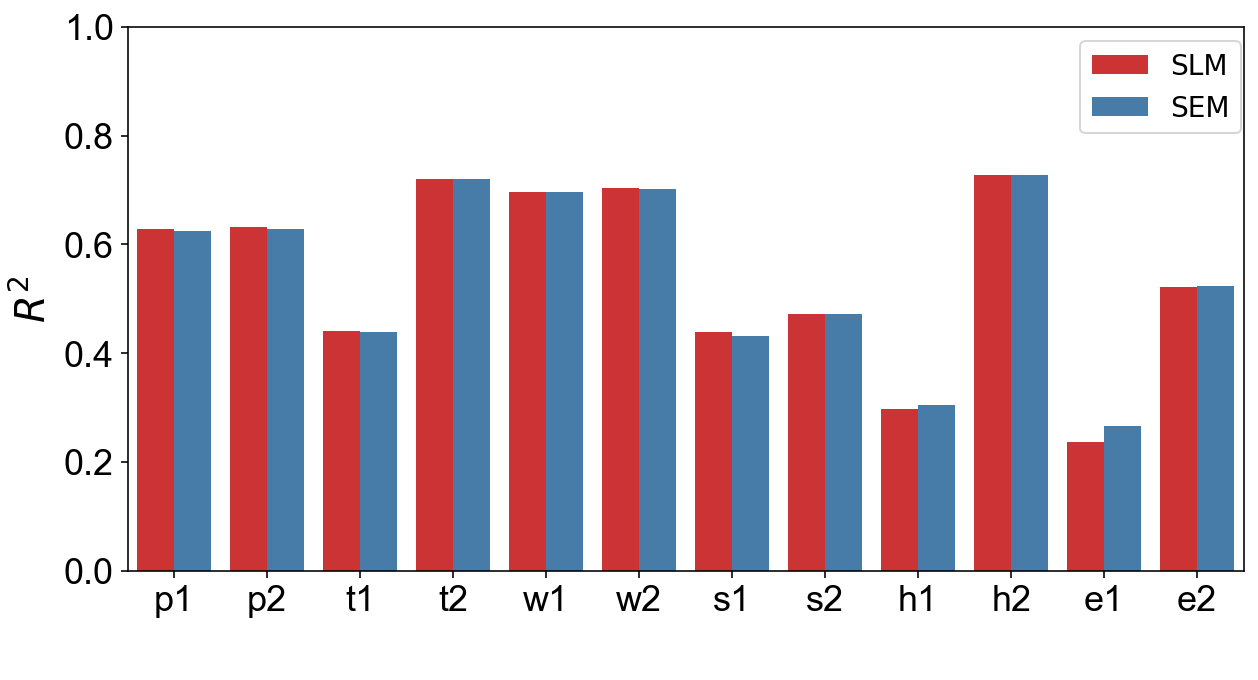

In [100]:
f, ax = plt.subplots(figsize=(10, 5))
ax = setFont(ax, 'Arial', 18)
sns.barplot(data=df_r2,hue='model',x='target_variable',y='r2', palette='Set1')
ax.set_ylabel(r'$R^2$', size=20)
ax.set_xlabel(r' ', size=20)
ax.legend(fontsize=14, bbox_to_anchor=(1.01,1))
ax.set_ylim((0,1))

<a id="gwr"></a> 
# 6. GWR: Weighted matrix
 * back to [Table of Contents](#toc)

In [101]:
def run_GWR_gaus(df,target_var,predictor_vars):
    X,y = extract_scale_features(df,target_var,predictor_vars)
    g_coords = list(df.g_coords.values)
    gwr_bandwidth = Sel_BW(g_coords, y, X, kernel='gaussian', fixed=True).search(criterion='AICc')
    estimator = GWR(g_coords, y, X, gwr_bandwidth, kernel='gaussian', fixed=True).fit()
    return estimator
def run_GWR_exp(df,target_var,predictor_vars):
    X,y = extract_scale_features(df,target_var,predictor_vars)
    g_coords = list(df.g_coords.values)
    gwr_bandwidth = Sel_BW(g_coords, y, X, kernel='exponential', fixed=True).search(criterion='AICc')
    estimator = GWR(g_coords, y, X, gwr_bandwidth, kernel='gaussian', fixed=True).fit()
    return estimator
def run_GWR_bi(df,target_var,predictor_vars):
    X,y = extract_scale_features(df,target_var,predictor_vars)
    g_coords = list(df.g_coords.values)
    gwr_bandwidth = Sel_BW(g_coords, y, X).search(criterion='AICc')
    estimator = GWR(g_coords, y, X, gwr_bandwidth, kernel='gaussian', fixed=True).fit()
    return estimator

In [102]:
selected_models={}
g_coords = list(dfData.g_coords.values)
for i,target in enumerate(target_variables):
    varnames = feature_selection(dfData,target)
    selected_feats[target] = varnames
    ##run the different models with the selected variables
    est_gaus = run_GWR_gaus(dfData,target,varnames)
    est_exp = run_GWR_exp(dfData,target,varnames)
    est_bi = run_GWR_bi(dfData,target,varnames)
    selected_models[target] = [est_gaus, est_exp, est_bi]

In [103]:
cols = ['target_variable','model','r2']
df_r2=pd.DataFrame(columns=cols)
for i,j in zip(selected_models.keys(),selected_models.values()):
    for est, model in zip(j,['Gaussian', 'Exponential', 'Bisquare']):
        df_r2=df_r2.append(pd.DataFrame(columns=cols,data=[[i,model,get_r2(est)]]),ignore_index=True)

(0.0, 1.0)

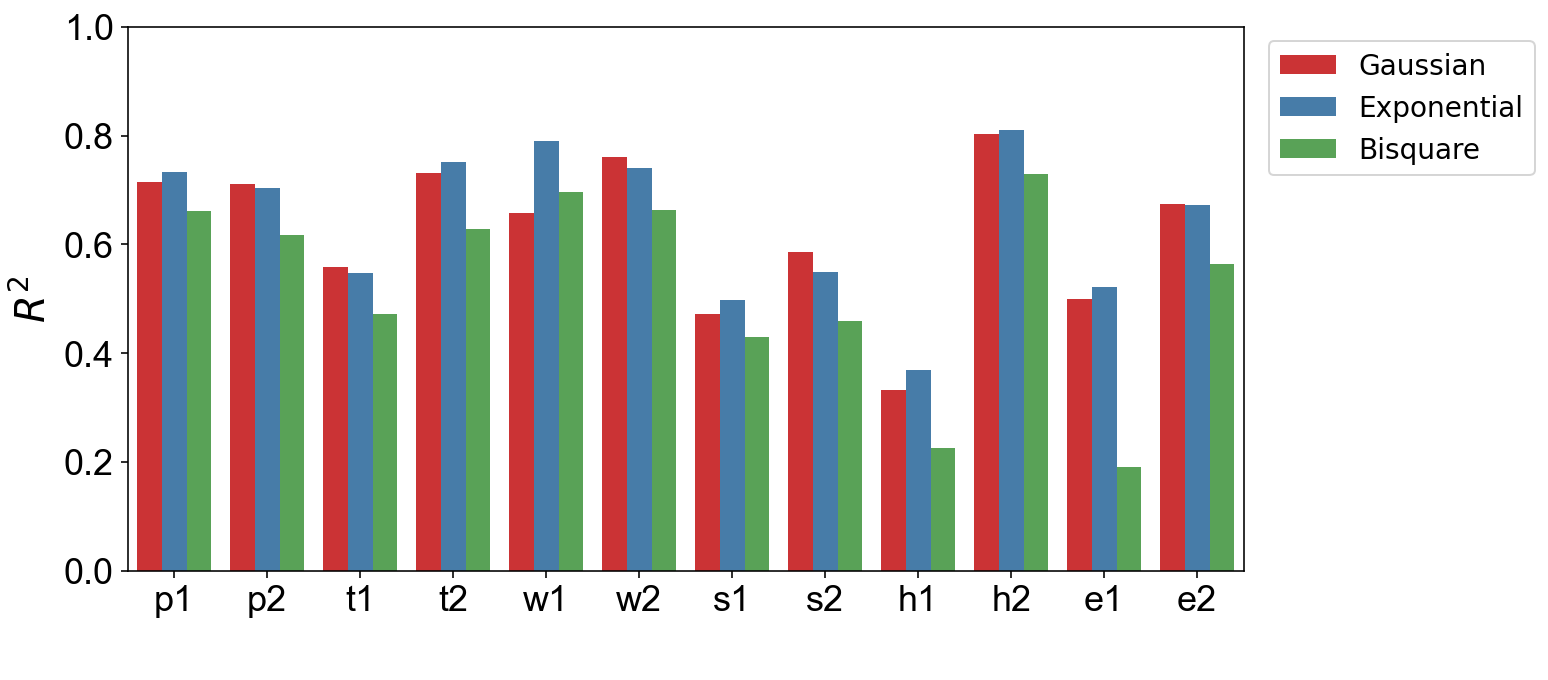

In [104]:
f, ax = plt.subplots(figsize=(10, 5))
ax = setFont(ax, 'Arial', 18)
sns.barplot(data=df_r2,hue='model',x='target_variable',y='r2', palette='Set1')
ax.set_ylabel(r'$R^2$', size=20)
ax.set_xlabel(r' ', size=20)
ax.legend(fontsize=14, bbox_to_anchor=(1.01,1))
ax.set_ylim((0,1))

<a id="slmscheme"></a> 
# 7. SLM: Different scheme
 * back to [Table of Contents](#toc)

In [105]:
def run_SLM(df,target_var, predictor_vars, W): 
    X,y = extract_scale_features(df,target_var,predictor_vars)
    estimator = GM_Lag(y, X, w=W, spat_diag=True, w_lags=2)        
    return estimator

In [106]:

ks = [1,2,3,4,5,6,7,8,9,10]
R2 = []
g_coords = list(dfData.g_coords.values)
for j in ks:
    r2 = []
    W_knn = generate_W_knn(dfData, 2, j)
    for i,target in enumerate(target_variables):
        varnames = feature_selection(dfData,target)
        selected_feats[target] = varnames
        ##run the different models with the selected variables
        est_slm = run_SLM(dfData,target,varnames, W_knn)
        r2.append(get_r2(est_slm))
    R2.append(r2)

(0.0, 1.0)

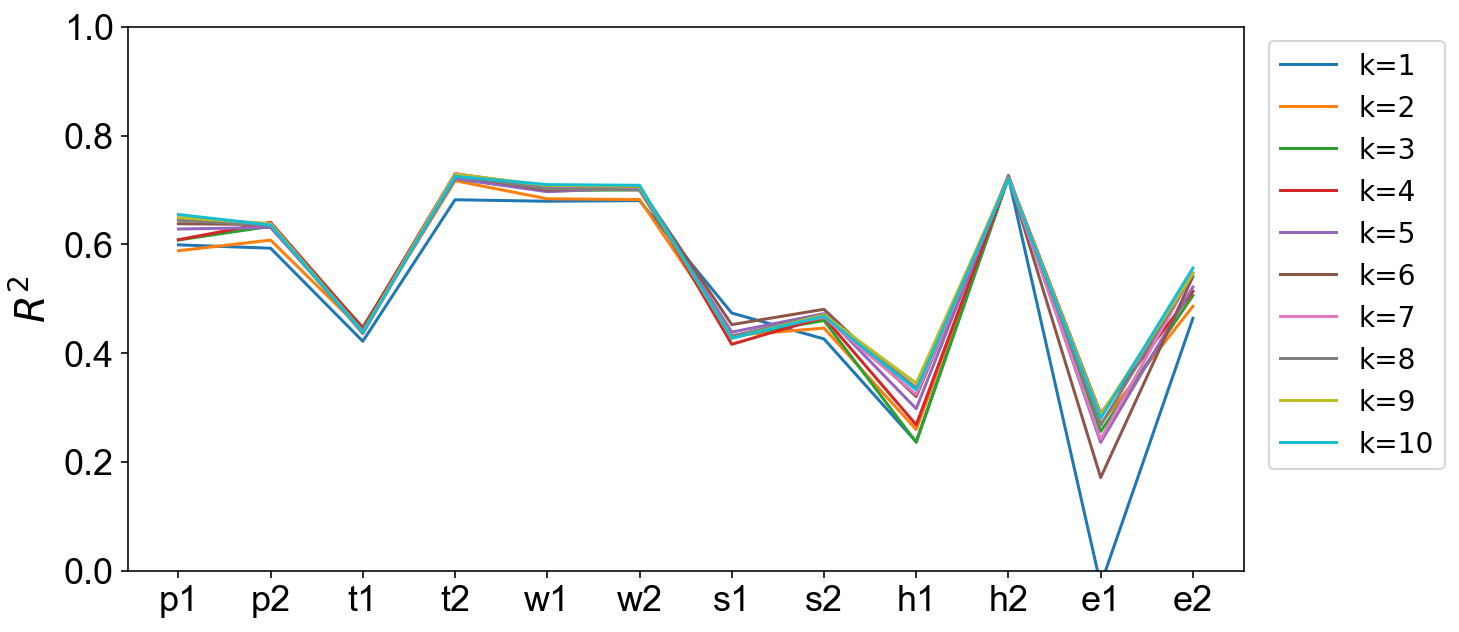

In [107]:
f, ax = plt.subplots(figsize=(10, 5))
ax = setFont(ax, 'Arial', 18)
plt.plot(tmp['target_variable'], R2[0], label='k=1')
plt.plot(R2[1], label='k=2')
plt.plot(R2[2], label='k=3')
plt.plot(R2[3], label='k=4')
plt.plot(R2[4], label='k=5')
plt.plot(R2[5], label='k=6')
plt.plot(R2[6], label='k=7')
plt.plot(R2[7], label='k=8')
plt.plot(R2[8], label='k=9')
plt.plot(R2[9], label='k=10')
ax.set_ylabel(r'$R^2$', size=20)
ax.legend(fontsize=14, bbox_to_anchor=(1.01,1))
ax.set_ylim((0,1))

In [108]:
## knn
def generate_W_knn(df, p, k):
    kd = libpysal.cg.KDTree(df[['Xcoord','Ycoord']].values)
    return libpysal.weights.KNN(kd, p=p, k=k)
W_knn = generate_W_knn(dfData, 2, 5)

In [109]:
## kernel
def generate_W_kernel(df):
    w = libpysal.weights.Kernel(df[['Xcoord','Ycoord']].values)
    w.transform = 'r'
    return libpysal.weights.insert_diagonal(w, np.zeros(w.n))
W_kernel = generate_W_kernel(dfData)

In [110]:
def run_SLM(df,target_var, predictor_vars, W): 
    X,y = extract_scale_features(df,target_var,predictor_vars)
    estimator = GM_Lag(y, X, w=W)        
    return estimator

In [111]:
R2 = []
W = [W_knn, W_kernel]
for j in W:
    r2 = []
    for i,target in enumerate(target_variables):
        varnames = feature_selection(dfData,target)
        selected_feats[target] = varnames
        ##run the different models with the selected variables
        est_slm = run_SLM(dfData,target,varnames, j)
        r2.append(get_r2(est_slm))
    R2.append(r2)

(0.0, 1.0)

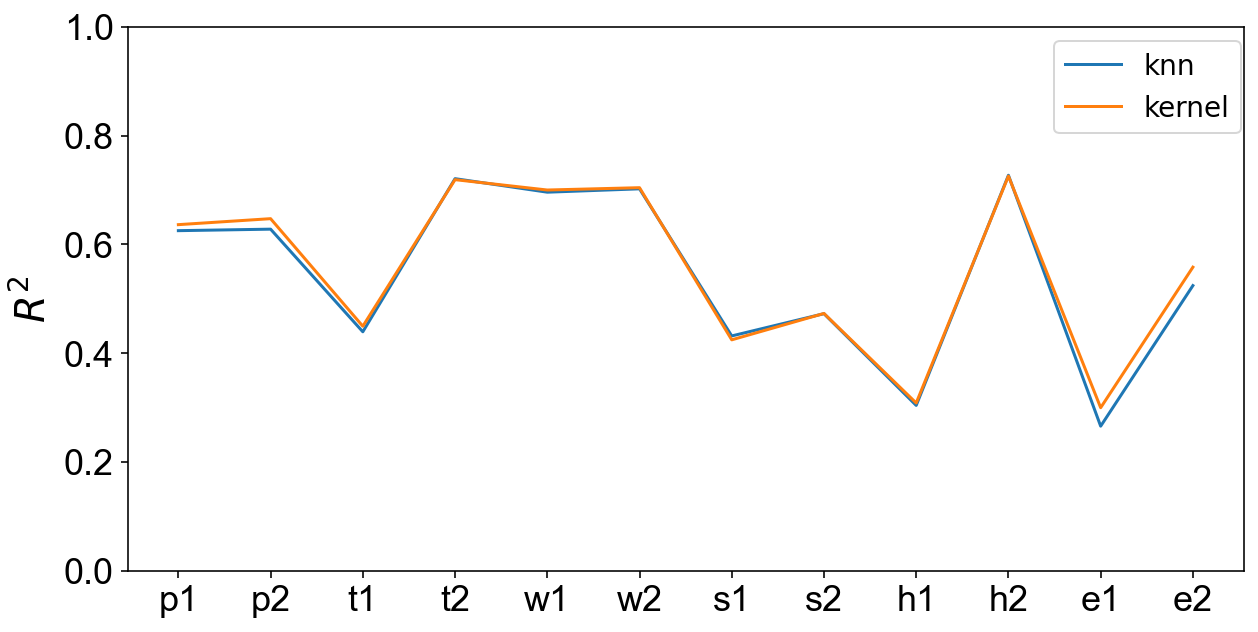

In [112]:
f, ax = plt.subplots(figsize=(10, 5))
ax = setFont(ax, 'Arial', 18)
plt.plot(tmp['target_variable'], R2[0], label = 'knn')
plt.plot(R2[1], label = 'kernel')
ax.set_ylim([0,1])
ax.set_ylabel(r'$R^2$', size=20)
ax.legend(fontsize=14, bbox_to_anchor=(1.01,1))
ax.set_ylim((0,1))